In [1]:

from ND_path_finder.src.data_generators.perlin_generator import PerlinNoiseGenerator
from ND_path_finder.src.data_samplers.random_sampler import sample_xarray
from ND_path_finder.src.edge_detection.SVM_boundary import SVMBoundary

In [2]:
# Initialize the generator with 2D resolution
generator_2D = PerlinNoiseGenerator(res=[100, 100], octv=6, seed=42, time_test=False)

# Generate Perlin noise data
xdataset_2D = generator_2D.perlin_data_xarray()

# generator.plot_2D_xarray()


In [3]:
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import xarray as xr
from numpy.linalg import norm
from scipy.interpolate import interp1d


def boundary_from_contour_with_gradients_2D(xx, yy, Z, boundary_resolution_len: float):
    plt.ioff()  # Turn interactive mode off to suppress showing plots

    # Extract decision boundary points using contour
    contours = plt.contour(xx, yy, Z, levels=[0], linewidths=1, colors="black")
    plt.close()

    # Get all paths
    paths = contours.allsegs[0]  # Get all segments for the contour level

    all_interpolated_points = []
    all_gradients = []

    for path_segment in paths:
        vertices = np.array(path_segment)
        distances = norm(vertices[1:] - vertices[:-1], axis=1)
        cumulative_distances = np.cumsum(distances)
        cumulative_distances = np.insert(cumulative_distances, 0, 0)

        # Interpolate points along the path
        path_length = cumulative_distances[-1]
        num_points = int(path_length // boundary_resolution_len) + 1
        evenly_spaced_distances = np.linspace(0, path_length, num=num_points)

        interp_fn = interp1d(cumulative_distances, vertices, axis=0, kind='linear')
        interpolated_points = interp_fn(evenly_spaced_distances)



        if len(interpolated_points) < 2:
            # Add a dummy gradient (e.g., zero) if only one point
            gradients = np.zeros_like(interpolated_points)
        else:
            # Compute gradient vectors (finite difference method)
            gradients = np.zeros_like(interpolated_points)
            for i in range(1, len(interpolated_points) - 1):
                tangent = interpolated_points[i + 1] - interpolated_points[i - 1]
                normal = np.array([-tangent[1], tangent[0]])  # Perpendicular vector
                normal /= norm(normal)  # Normalize the gradient
                gradients[i] = normal * 0.1  # Scale the gradient (optional)

            # Set boundary gradients for the endpoints
            gradients[0] = gradients[1]
            gradients[-1] = gradients[-2]

        # Store points and gradients
        all_interpolated_points.append(interpolated_points)
        all_gradients.append(gradients)



        # Store points and gradients
        all_interpolated_points.append(interpolated_points)
        all_gradients.append(gradients)

    return all_interpolated_points, all_gradients


def plot_2D_boundary(X, y, xx, yy, Z, interp_boundary_points, boundary_gradients):
    # Plot the decision boundary and data points
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=5, label="Data Points")
    plus_minus = 0.1
    # plt.contour(xx, yy, Z, levels=[-plus_minus,0,plus_minus], linestyles=['-'], colors='k')
    plt.contour(xx, yy, Z, levels=[0,plus_minus], linestyles=['-'], colors='k')

    # Plot interpolated points and gradient vectors
    # for i, interpolated_points in enumerate(interp_boundary_points):
    #     plt.plot(interpolated_points[:, 0], interpolated_points[:, 1], 'go', markersize=5, label=f'Boundary Points (Path {i+1})')



    # Plot boundary points and gradient vectors
    for i, (interpolated_points, gradients) in enumerate(zip(interp_boundary_points, boundary_gradients)):
        plt.plot(interpolated_points[:, 0], interpolated_points[:, 1], 'go', markersize=5)
        plt.quiver(
            interpolated_points[:, 0], interpolated_points[:, 1],
            gradients[:, 0]*.005, gradients[:, 1]*.005,
            angles='xy', scale_units='xy', scale=0.01, color='r', alpha=0.8, headwidth=3
        )

    # Add plot details
    plt.title("SVM Decision Boundary with Gradient Vectors")
    plt.xlim(X[:, 0].min(), X[:, 0].max())
    plt.ylim(X[:, 1].min(), X[:, 1].max())
    plt.xlabel("x0")
    plt.ylabel("x1")
    plt.legend()
    plt.show()




def svm_boundary_from_xarray_2D(dataset:xr.Dataset, boundary_resolution_len=0.5, boundary_mesh_resolution = 500):
    """
    Fits an SVM model to the data in the xarray.Dataset and plots the decision boundary.

    Parameters:
    - dataset (xarray.Dataset): The input dataset containing 'points' and 'noise_values'.

    Returns:
    - None: Plots the SVM decision boundary and data points.
    """

    # Ensure the required variables are present
    if not {'points', 'noise_values'}.issubset(dataset.variables):
        raise ValueError("Dataset must contain 'points' and 'noise_values' variables.")

    # Extract features and labels
    X = dataset['points'].values  # Shape (num_points, dim)
    y = dataset['noise_values'].values  # Shape (num_points,)


    # Define the parameter grid for grid search
    param_grid = {
        'C': [0.01, 0.1, 1, 5, 10, 100],  # Regularization parameter
        'gamma': [0.001, 0.1, 0.5, 1, 5, 10, 50, 100]  # Kernel coefficient
    }


    # Perform grid search to find the best parameters
    svc = SVC(kernel='rbf')
    grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X, y)

    # Get the best model
    best_svm = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")




    # Create a grid for decision boundary visualization
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, boundary_mesh_resolution),
                        np.linspace(y_min, y_max, boundary_mesh_resolution))

    # Evaluate the decision function
    Z = best_svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # interp_boundary_points = boundary_from_contour(xx, yy, Z, boundary_resolution_len)


    interp_boundary_points, boundary_gradients = boundary_from_contour_with_gradients_2D(xx, yy, Z, boundary_resolution_len)


    # Ensure 2D data for visualization
    if X.shape[1] == 2:
        plot_2D_boundary(X, y, xx, yy, Z, interp_boundary_points, boundary_gradients)


Best parameters: {'C': 10, 'gamma': 100}


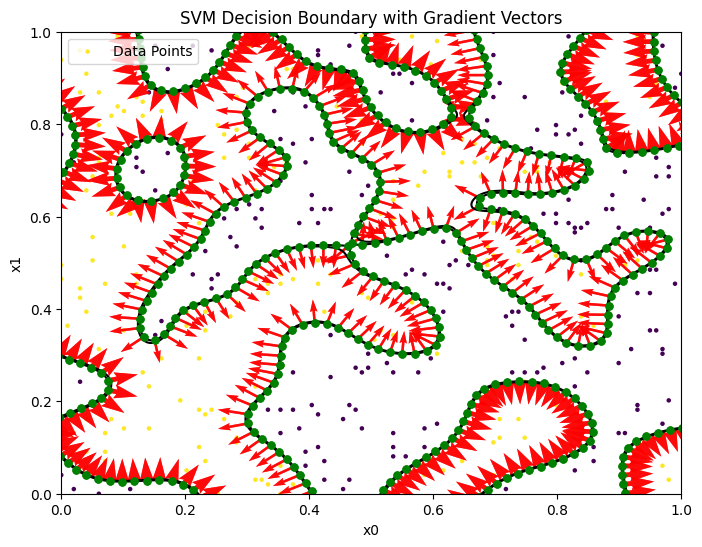

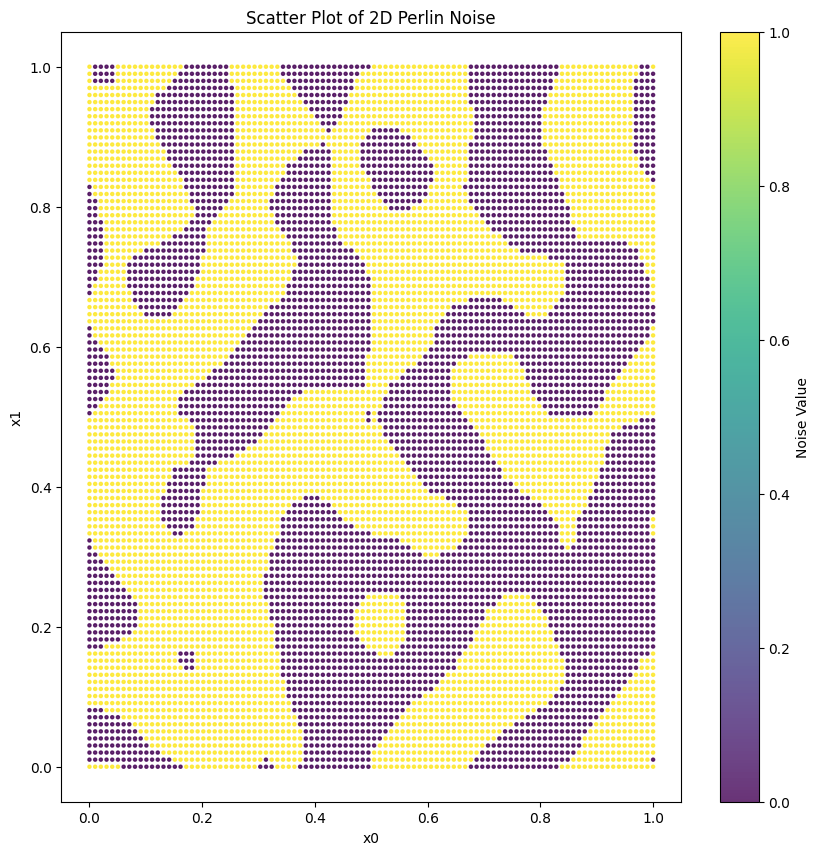

In [4]:
svm_boundary_from_xarray_2D(sample_xarray(xdataset_2D, 400), boundary_resolution_len=0.02)

generator_2D.plot_2D_xarray()

# 3D case

In [5]:
# Initialize the generator with 2D resolution
generator_3D = PerlinNoiseGenerator(res=[30, 30, 30], octv=3, seed=47, time_test=False)

# Generate Perlin noise data
xdataset_3D = generator_3D.perlin_data_xarray()

# generator.plot_2D_xarray()


In [19]:
from sklearn.svm import SVC
import numpy as np
from sklearn.model_selection import GridSearchCV
from scipy.interpolate import griddata
from scipy.spatial.distance import pdist, squareform
from numpy.linalg import norm

from scipy.spatial import KDTree
from scipy.interpolate import griddata
import numpy as np
from numpy.linalg import norm


def boundary_from_contour_with_gradients_3D(boundary_points, boundary_resolution_len: float):
    """
    Generalized boundary extraction and gradient calculation for 3D data.

    Parameters:
    - boundary_points (np.ndarray): Points on the boundary, shape (num_points, 3).
    - boundary_resolution_len (float): Distance between interpolated boundary points.

    Returns:
    - interpolated_points (np.ndarray): Interpolated boundary points, shape (num_interpolated_points, 3).
    - gradients (np.ndarray): Gradient vectors at interpolated points, shape (num_interpolated_points, 3).
    """
    if boundary_points.shape[0] < 2:
        raise ValueError("Insufficient boundary points for interpolation.")

    # Create a KDTree for nearest neighbor queries
    tree = KDTree(boundary_points)

    # Compute cumulative distances along the boundary
    visited = set()
    current_point = boundary_points[0]
    path = [current_point]
    visited.add(tuple(current_point))

    while len(visited) < len(boundary_points):
        distances, indices = tree.query(current_point, k=len(boundary_points))
        for idx in indices:
            next_point = boundary_points[idx]
            if tuple(next_point) not in visited:
                path.append(next_point)
                visited.add(tuple(next_point))
                current_point = next_point
                break

    path = np.array(path)

    # Compute cumulative distances along the path
    segment_distances = norm(path[1:] - path[:-1], axis=1)
    cumulative_distances = np.insert(np.cumsum(segment_distances), 0, 0)

    # Interpolate points along the path
    path_length = cumulative_distances[-1]
    num_points = int(path_length // boundary_resolution_len) + 1
    evenly_spaced_distances = np.linspace(0, path_length, num=num_points)
    interpolated_points = griddata(
        cumulative_distances, path, evenly_spaced_distances, method="linear"
    )

    # Compute gradients at interpolated points
    gradients = np.zeros_like(interpolated_points)
    if len(interpolated_points) > 1:
        for i in range(1, len(interpolated_points) - 1):
            tangent = interpolated_points[i + 1] - interpolated_points[i - 1]
            normal = tangent / (norm(tangent) + 1e-9)  # Avoid division by zero
            gradients[i] = normal * 0.1  # Scale the gradient (optional)

        # Set boundary gradients for the endpoints
        gradients[0] = gradients[1]
        gradients[-1] = gradients[-2]

    return interpolated_points, gradients


def svm_boundary_from_xarray_ND(dataset, boundary_resolution_len=0.5, boundary_mesh_resolution=50):
    """
    Fits an SVM model to N-dimensional data and extracts the decision boundary.

    Parameters:
    - dataset (xarray.Dataset): The input dataset containing 'points' and 'noise_values'.

    Returns:
    - None
    """
    if not {"points", "noise_values"}.issubset(dataset.variables):
        raise ValueError("Dataset must contain 'points' and 'noise_values' variables.")

    X = dataset["points"].values  # Shape (num_points, dim)
    y = dataset["noise_values"].values  # Shape (num_points,)

    param_grid = {"C": [0.01, 0.1, 1, 5, 10], "gamma": [0.1, 0.5, 1, 5, 10]}
    svc = SVC(kernel="rbf")
    grid_search = GridSearchCV(svc, param_grid, cv=5, scoring="accuracy")
    grid_search.fit(X, y)

    best_svm = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")

    # Generate a grid in N-dimensions
    dims = X.shape[1]
    grid_ranges = [np.linspace(X[:, i].min() - 0.1, X[:, i].max() + 0.1, boundary_mesh_resolution) for i in range(dims)]
    grid_mesh = np.meshgrid(*grid_ranges, indexing="ij")
    grid_points = np.stack([g.ravel() for g in grid_mesh], axis=-1)

    Z = best_svm.decision_function(grid_points)

    interp_boundary_points, boundary_gradients = boundary_from_contour_with_gradients_ND(
        grid_points, Z, boundary_resolution_len
    )

    return interp_boundary_points, boundary_gradients


In [20]:
svm_boundary_from_xarray_ND(sample_xarray(xdataset_2D, 200), boundary_resolution_len=0.02)


Best parameters: {'C': 5, 'gamma': 1}
Boundary points shape: (8, 2)
Boundary points (sample): [[0.61020408 0.43877551]
 [0.61020408 0.73265306]
 [0.68367347 0.29183673]
 [0.68367347 0.87959184]
 [0.70816327 0.90408163]]


ValueError: Cumulative distances are degenerate. Check boundary points.

In [21]:
svm_boundary_from_xarray_ND(sample_xarray(xdataset_3D, 400), boundary_resolution_len=0.02)


Best parameters: {'C': 10, 'gamma': 10}
Boundary points shape: (517, 3)
Boundary points (sample): [[-0.1        -0.05102041  0.21836735]
 [-0.1        -0.00204082  0.21836735]
 [-0.1         0.34081633  1.02653061]
 [-0.1         0.38979592  0.56122449]
 [-0.1         0.38979592  0.68367347]]


ValueError: Cumulative distances are degenerate. Check boundary points.

In [8]:
# Plot the identified boundaries
# SVMBoundary(sample_xarray(xdataset_2D, 1000)).plot_traversed_boundaries()